# This notebook has the code to generate plots 3,4 and 5  </span>

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [5]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [6]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50

################################
cesm2_path    = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
landfrac_path = '/global/scratch/users/harsha/LENS/cesm2/landfrac/'
cvals         = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals1        = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
cvals_det     = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
##############################
print(cleft,cright)
print(euleft,euright)

235.21559209999998 293.0486188
350.0 50


In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39565 instead
  warnings.warn(


In [8]:
cluster

Dashboard: http://10.0.39.1:39565/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:45251,Workers: 0
Dashboard: http://10.0.39.1:39565/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [10]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'},skipna=True)
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [11]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [13]:
%%time 
landfrac = xr.open_mfdataset(landfrac_path+'*.nc',engine='netcdf4')
landfrac = landfrac.LANDFRAC
landfrac

CPU times: user 756 ms, sys: 94.9 ms, total: 851 ms
Wall time: 974 ms


<xarray.DataArray 'LANDFRAC' (time: 192, lat: 192, lon: 288)>
dask.array<concatenate, shape=(192, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

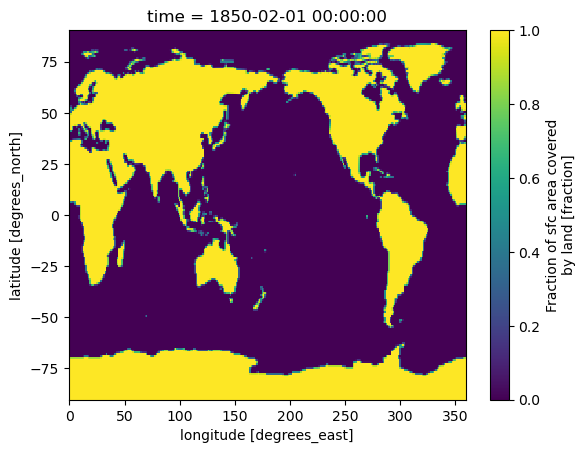

In [14]:
landfrac.sel(time='18500201').plot()

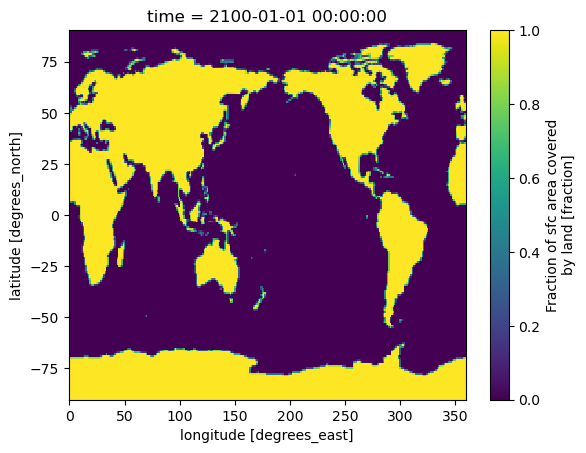

In [15]:
landfrac.sel(time='21000101').plot()

In [16]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 3.5 s, sys: 391 ms, total: 3.89 s
Wall time: 4.02 s


In [17]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
#tgnw

CPU times: user 600 ms, sys: 18 ms, total: 618 ms
Wall time: 606 ms


In [18]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 5.39 s, sys: 256 ms, total: 5.64 s
Wall time: 6.62 s


<xarray.DataArray 'TREFHTMX' (time: 21900, lat: 192, lon: 288, member: 100)>
dask.array<rechunk-merge, shape=(21900, 192, 288, 100), dtype=float32, chunksize=(900, 20, 30, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [19]:
%%time
########### Save the absolute errors ############
#DJF
qgmsc_djf_errpath     = cvals_det+'qgmsc_detssn_err_'   +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_djf_errpath    = cvals_det+'qgauss_detssn_err_'  +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_djf_errpath      = cvals_det+'qgmc_detssn_err_'    +'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_djf_errpath  = cvals_det+'qgaussmo_detssn_err_'+'djf' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#MAM
qgmsc_mam_errpath     = cvals_det+'qgmsc_detssn_err_'   +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_mam_errpath    = cvals_det+'qgauss_detssn_err_'  +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_mam_errpath      = cvals_det+'qgmc_detssn_err_'    +'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_mam_errpath  = cvals_det+'qgaussmo_detssn_err_'+'mam' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#JJA
qgmsc_jja_errpath     = cvals_det+'qgmsc_detssn_err_'   +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_jja_errpath    = cvals_det+'qgauss_detssn_err_'  +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_jja_errpath      = cvals_det+'qgmc_detssn_err_'    +'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_jja_errpath  = cvals_det+'qgaussmo_detssn_err_'+'jja' +'_'+ic_year0+'_'+ic_year1+'.zarr'
#SON
qgmsc_son_errpath     = cvals_det+'qgmsc_detssn_err_'   +'son' +'_'+ic_year0+'_'+ic_year1+'.zarr' 
qgauss_son_errpath    = cvals_det+'qgauss_detssn_err_'  +'son' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_son_errpath      = cvals_det+'qgmc_detssn_err_'    +'son' +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_son_errpath  = cvals_det+'qgaussmo_detssn_err_'+'son' +'_'+ic_year0+'_'+ic_year1+'.zarr'

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 77.2 µs


In [20]:
##### Open ########
qgmsc_djf_err    = xr.open_zarr(qgmsc_djf_errpath).Errors
qgauss_djf_err   = xr.open_zarr(qgauss_djf_errpath).Errors
qgmc_djf_err     = xr.open_zarr(qgmc_djf_errpath).Errors
qgaussmo_djf_err   = xr.open_zarr(qgaussmo_djf_errpath).Errors

In [21]:
##### Open ########
qgmsc_mam_err     = xr.open_zarr(qgmsc_mam_errpath).Errors
qgauss_mam_err    = xr.open_zarr(qgauss_mam_errpath).Errors
qgmc_mam_err      = xr.open_zarr(qgmc_mam_errpath).Errors
qgaussmo_mam_err  = xr.open_zarr(qgaussmo_mam_errpath).Errors

In [22]:
##### Open ########
qgmsc_jja_err    = xr.open_zarr(qgmsc_jja_errpath).Errors
qgauss_jja_err   = xr.open_zarr(qgauss_jja_errpath).Errors
qgmc_jja_err     = xr.open_zarr(qgmc_jja_errpath).Errors
qgaussmo_jja_err   = xr.open_zarr(qgaussmo_jja_errpath).Errors

In [23]:
##### Open ########
qgmsc_son_err    = xr.open_zarr(qgmsc_son_errpath).Errors
qgauss_son_err   = xr.open_zarr(qgauss_son_errpath).Errors
qgmc_son_err     = xr.open_zarr(qgmc_son_errpath).Errors
qgaussmo_son_err = xr.open_zarr(qgaussmo_son_errpath).Errors

In [24]:
####### Plot errors for all seasons #############

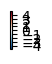

In [25]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

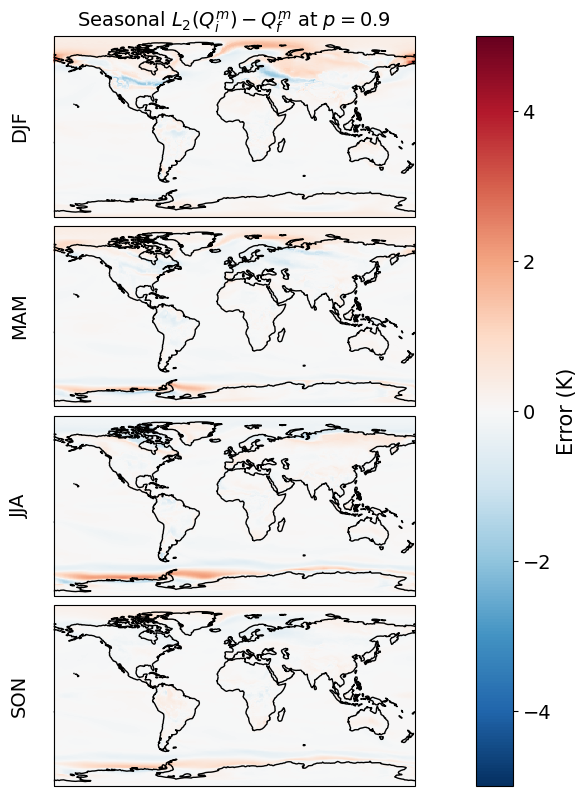

CPU times: user 2min 24s, sys: 7.28 s, total: 2min 31s
Wall time: 2min 41s


In [26]:
%%time
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(13.5,10), 
                        subplot_kw={'projection': cart.crs.PlateCarree()}) 
                        #gridspec_kw = {'wspace':0.02, 'hspace':0.01,'top':0.4,'bottom':0.1})

# # Reduce the padding around each subplot
#plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Adding titles for the rows
fig.text(0.47, 0.86, 'DJF', va='center', rotation='vertical',fontsize=14)
fig.text(0.47, 0.67, 'MAM', va='center', rotation='vertical',fontsize=14)
fig.text(0.47, 0.48, 'JJA', va='center', rotation='vertical',fontsize=14)
fig.text(0.47, 0.29, 'SON', va='center', rotation='vertical',fontsize=14)

# Plotting qgmsc_err1
im1= qgmsc_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(r'Seasonal $L_2(Q_i^m) - Q_f^m$ at $p=0.9$',fontsize=14)
#
im2 = qgmsc_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title('')
#
im3 = qgmsc_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[2].coastlines(color="black")
axs[2].set_title('')
#
im4 = qgmsc_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[3].coastlines(color="black")
axs[3].set_title('')

# Creating a mappable object for the colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.001, hspace=0.05)

# Adding colorbar
cbar = plt.colorbar(mappable, ax=axs.ravel().tolist(), shrink=1, orientation='vertical')
cbar.set_label('Error (K)',fontsize=15)
cbar.ax.tick_params(labelsize=14)  
#fig.tight_layout()
plt.show()

In [27]:
########################################

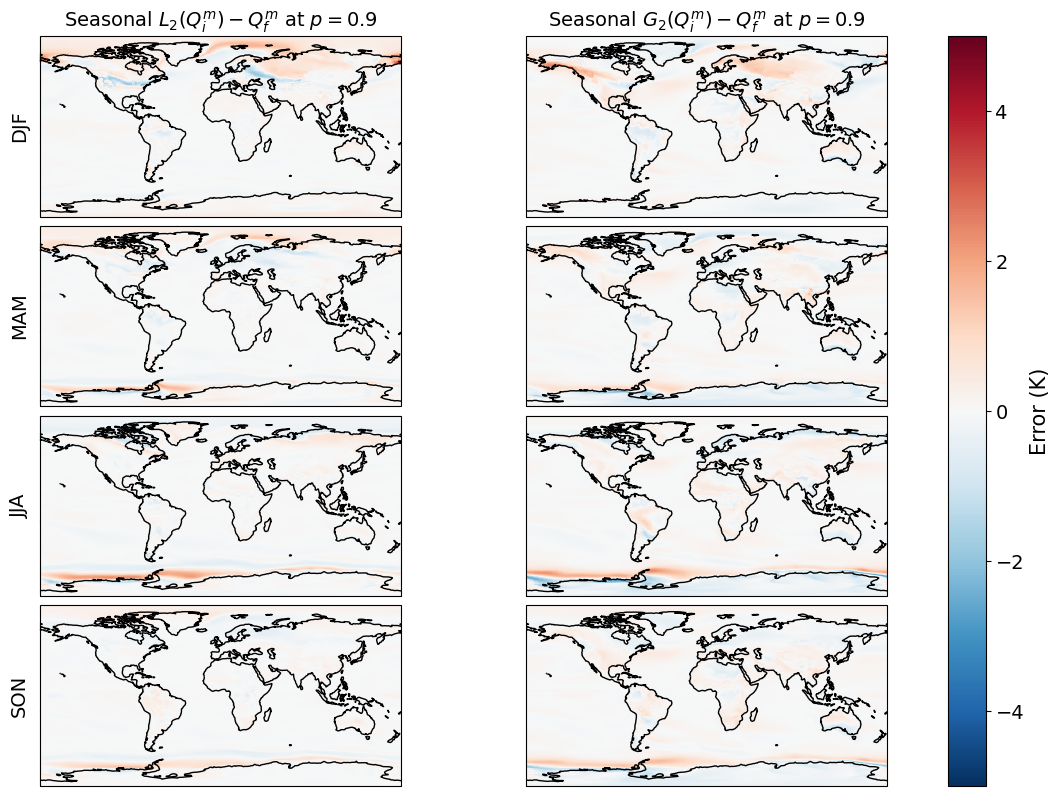

CPU times: user 4min 27s, sys: 13 s, total: 4min 40s
Wall time: 4min 43s


In [28]:
%%time
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13.5,10), 
                        subplot_kw={'projection': cart.crs.PlateCarree()}) 
                        #gridspec_kw = {'wspace':0.02, 'hspace':0.01,'top':0.4,'bottom':0.1})

# # Reduce the padding around each subplot
#plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Adding titles for the rows
fig.text(0.12, 0.86, 'DJF', va='center', rotation='vertical',fontsize=14)
fig.text(0.12, 0.67, 'MAM', va='center', rotation='vertical',fontsize=14)
fig.text(0.12, 0.48, 'JJA', va='center', rotation='vertical',fontsize=14)
fig.text(0.12, 0.29, 'SON', va='center', rotation='vertical',fontsize=14)

# Plotting qgmsc_err1
im1= qgmsc_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 0].coastlines(color="black")
axs[0, 0].set_title(r'Seasonal $L_2(Q_i^m) - Q_f^m$ at $p=0.9$',fontsize=14)
#
im2 = qgmsc_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 0].coastlines(color="black")
axs[1, 0].set_title('')
#
im3 = qgmsc_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 0].coastlines(color="black")
axs[2, 0].set_title('')
#
im4 = qgmsc_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 0].coastlines(color="black")
axs[3, 0].set_title('')

##### DJF #################
# # Plotting qgauss_err1
im5 = qgauss_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 1].coastlines(color="black")
axs[0, 1].set_title(r'Seasonal $G_2(Q_i^m) - Q_f^m$ at $p=0.9$',fontsize=14)

######## Plotting MAM #######################
# Plotting qgauss_err1
im6 = qgauss_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 1].coastlines(color="black")
axs[1, 1].set_title('')

######## Plotting JJA #######################

# Plotting qgauss_err1
im7 = qgauss_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 1].coastlines(color="black")
axs[2, 1].set_title('')
######## Plotting SON #######################

# Plotting qgauss_err1
im8 = qgauss_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 1].coastlines(color="black")
axs[3, 1].set_title('')

# Creating a mappable object for the colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.001, hspace=0.05)

# Adding colorbar
cbar = plt.colorbar(mappable, ax=axs.ravel().tolist(), shrink=1, orientation='vertical')
cbar.set_label('Error (K)',fontsize=15)
cbar.ax.tick_params(labelsize=14)  
#fig.tight_layout()
plt.show()

In [29]:
%%time
qgmsc_err = xr.concat([qgmsc_djf_err,qgmsc_mam_err,qgmsc_jja_err,qgmsc_son_err],dim='day')
qgmc_err  = xr.concat([qgmc_djf_err,qgmc_mam_err,qgmc_jja_err,qgmc_son_err],dim='day')
#qgmsc_err

CPU times: user 439 ms, sys: 72.2 ms, total: 511 ms
Wall time: 508 ms


In [30]:
%%time
qgauss_err   = xr.concat([qgauss_djf_err,qgauss_mam_err,qgauss_jja_err,qgauss_son_err],dim='day')
qgaussmo_err = xr.concat([qgaussmo_djf_err,qgaussmo_mam_err,qgaussmo_jja_err,qgaussmo_son_err],dim='day')
#qgauss_err

CPU times: user 438 ms, sys: 89.4 ms, total: 527 ms
Wall time: 550 ms


In [31]:
#qgaussmo_err.values

### Get masked arrays for land and ocean 

In [33]:
# %%time
# landfrac        = landfrac.sel(time='21000101')
# qgmsc_abserr    = (np.fabs(qgmsc_err) < 1.0)
# qgauss_abserr   = (np.fabs(qgauss_err) < 1.0)
# qgauss_abserr

CPU times: user 44.6 ms, sys: 8.71 ms, total: 53.3 ms
Wall time: 49.7 ms


<xarray.DataArray 'Errors' (quantile: 101, lat: 192, lon: 288, day: 365)>
dask.array<lt, shape=(101, 192, 288, 365), dtype=bool, chunksize=(101, 20, 40, 10), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 327 328 329 330 331 332 333 334
    degree    int64 1
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086

In [34]:
# %%time
# M                     = 192*288*365
# qgmsc_err_fracn1      = qgmsc_abserr.sum({'day','lat','lon'})/M
# qgauss_err_fracn1     = qgauss_abserr.sum({'day','lat','lon'})/M
# #### Land #######
# qgmsc_land_errfracn1  = qgmsc_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
# qgauss_land_errfracn1 = qgauss_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
# #### Ocean ######
# qgmsc_ocean_errfracn1 = qgmsc_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)
# qgauss_ocean_errfracn1= qgauss_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)

CPU times: user 2.24 s, sys: 80.1 ms, total: 2.32 s
Wall time: 2.34 s


In [35]:
#landfrac.values

In [36]:
# %%time
M                      = 192*288*365
# qgmw_diff_fracn0.5     = (np.fabs(qgmw_diff) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff1_fracn0.5 = (np.fabs(qgmw_reldiff1) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff2_fracn0.5 = (np.fabs(qgmw_reldiff2) < 0.5).sum({'day','lat','lon'})/M

In [37]:
# qgmsc_err_chk      = (np.fabs(qgmsc_err) < 1.0)
# qgmsc_land_err_chk = qgmsc_err_chk.where(landfrac==1).mean(['day','lat','lon'],skipna=True)
# qgmsc_land_err_chk.plot()

In [38]:
quants = np.arange(0.0,1.01,0.01)

In [39]:
# %%time
# ########### Save the fracn of errors <1K  ############
# qgmsc_errfracn1path           = cvals+'qgmsc_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qgauss_errfracn1path          = cvals+'qgauss_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# #### Land #######
# qgmsc_land_errfracn1path   = cvals+'qgmsc_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qgauss_land_errfracn1path  = cvals+'qgauss_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# ##### Ocean #####
# qgmsc_ocean_errfracn1path  = cvals+'qgmsc_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qgauss_ocean_errfracn1path = cvals+'qgauss_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# ########################################
# # qgmsc_land_errfracn1.to_dataset().to_zarr(qgmsc_land_errfracn1path,mode='w')
# # qgauss_land_errfracn1.to_dataset().to_zarr(qgauss_land_errfracn1path,mode='w')
# # #
# # qgmsc_ocean_errfracn1.to_dataset().to_zarr(qgmsc_ocean_errfracn1path,mode='w')
# # qgauss_ocean_errfracn1.to_dataset().to_zarr(qgauss_ocean_errfracn1path,mode='w')
# # #
# # qgmsc_err_fracn1.to_dataset().to_zarr(qgmsc_errfracn1path,mode='w')
# # qgauss_err_fracn1.to_dataset().to_zarr(qgauss_errfracn1path,mode='w')

CPU times: user 41 µs, sys: 0 ns, total: 41 µs
Wall time: 94.2 µs


In [40]:
# ########### Open and PLot ############
# qgmsc_land_errfracn1  = xr.open_zarr(qgmsc_land_errfracn1path).Errors
# qgauss_land_errfracn1 = xr.open_zarr(qgauss_land_errfracn1path).Errors
# #
# qgmsc_ocean_errfracn1 = xr.open_zarr(qgmsc_ocean_errfracn1path).Errors
# qgauss_ocean_errfracn1= xr.open_zarr(qgauss_ocean_errfracn1path).Errors
# #
# qgmsc_errfracn1       = xr.open_zarr(qgmsc_errfracn1path).Errors
# qgauss_errfracn1      = xr.open_zarr(qgauss_errfracn1path).Errors

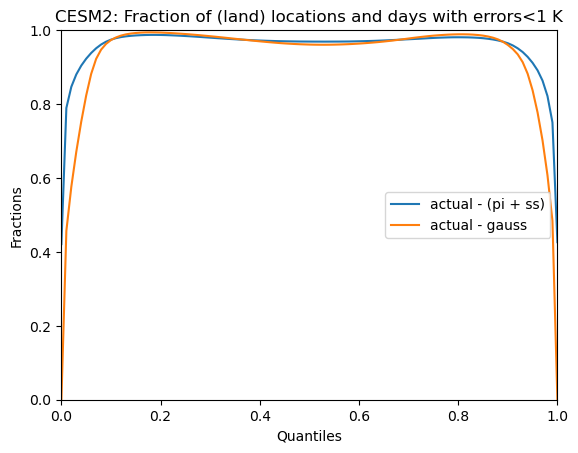

CPU times: user 1.58 s, sys: 91.1 ms, total: 1.67 s
Wall time: 1.64 s


In [41]:
# %%time
# quants = np.arange(0,1.01,0.01)
# plt.plot(quants,qgmsc_land_errfracn1,label='actual - (pi + ss)', c='tab:blue')
# plt.plot(quants,qgauss_land_errfracn1,label='actual - gauss',c='tab:orange')
# #plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
# plt.legend(loc='center right')
# plt.title('CESM2: Fraction of (land) locations and days with errors<1 K')
# plt.ylabel('Fractions')
# plt.xlabel('Quantiles')
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
# plt.show()

In [42]:
#qgmw_reldiff2_fracn0.values

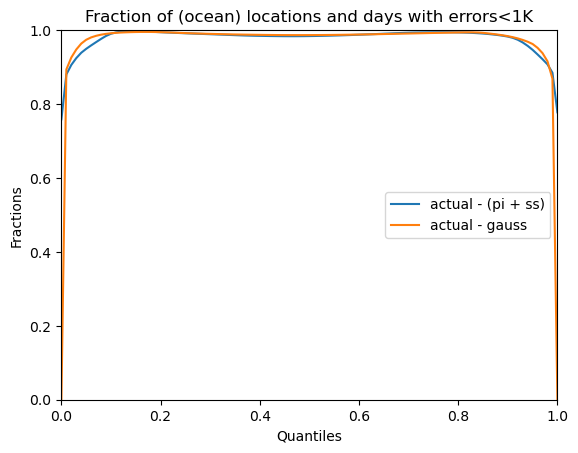

CPU times: user 1.62 s, sys: 121 ms, total: 1.74 s
Wall time: 1.66 s


In [43]:
# %%time
# plt.plot(quants,qgmsc_ocean_errfracn1,label='actual - (pi + ss)', c='tab:blue')
# plt.plot(quants,qgauss_ocean_errfracn1,label='actual - gauss',c='tab:orange')
# #plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
# plt.legend(loc='center right')
# plt.title('Fraction of (ocean) locations and days with errors<1K')
# plt.ylabel('Fractions')
# plt.xlabel('Quantiles')
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
# plt.show()

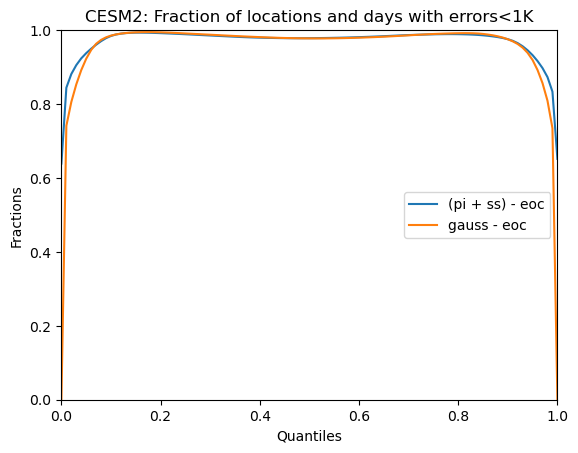

CPU times: user 1.52 s, sys: 99.1 ms, total: 1.62 s
Wall time: 1.55 s


In [44]:
# %%time
# plt.plot(quants,qgmsc_errfracn1,label='(pi + ss) - eoc', c='tab:blue')
# plt.plot(quants,qgauss_errfracn1,label='gauss - eoc',c='tab:orange')
# #plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
# plt.legend(loc='center right')
# plt.title('CESM2: Fraction of locations and days with errors<1K')
# plt.ylabel('Fractions')
# plt.xlabel('Quantiles')
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,1.0)
# plt.show()

In [45]:
############## Plot 5 #########################

In [46]:
############# Compute area-weighted mean square of the above errors #####################

In [47]:
# g = global, l=land, o=ocean
qgmsc_grmse     = global_annual_rmse(qgmsc_err,'day')
qgauss_grmse    = global_annual_rmse(qgauss_err,'day')
qgmc_grmse      = global_annual_rmse(qgmc_err,'day')
qgaussmo_grmse  = global_annual_rmse(qgaussmo_err,'day')
qgmsc_lrmse     = global_annual_rmse(qgmsc_err.where(landfrac==1),'day')
qgauss_lrmse    = global_annual_rmse(qgauss_err.where(landfrac==1),'day')
qgmsc_ormse     = global_annual_rmse(qgmsc_err.where(landfrac==0),'day')
qgauss_ormse    = global_annual_rmse(qgauss_err.where(landfrac==0),'day')

In [48]:
%%time
qgmsc_aerr     = np.fabs(qgmsc_err)
qgauss_aerr    = np.fabs(qgauss_err)
qgmc_aerr      = np.fabs(qgmc_err)
qgaussmo_aerr  = np.fabs(qgaussmo_err)
######
qgmsc_lmae    = global_mean(qgmsc_aerr.where(landfrac==1))
qgauss_lmae   = global_mean(qgauss_aerr.where(landfrac==1))
qgmsc_omae    = global_mean(qgmsc_aerr.where(landfrac==0))
qgauss_omae   = global_mean(qgauss_aerr.where(landfrac==0))
######
qgmsc_gmae    = global_mean(qgmsc_aerr)
qgauss_gmae   = global_mean(qgauss_aerr)
qgmc_gmae     = global_mean(qgmc_aerr)
qgaussmo_gmae = global_mean(qgaussmo_aerr)
##########
qgmsc_gmae    = qgmsc_gmae.rename('Error')
qgauss_gmae   = qgauss_gmae.rename('Error')
qgmc_gmae     = qgmc_gmae.rename('Error')
qgaussmo_gmae = qgaussmo_gmae.rename('Error')
#####
qgmsc_lmae    = qgmsc_lmae.rename('Error')
qgauss_lmae   = qgauss_lmae.rename('Error')
qgmsc_omae    = qgmsc_omae.rename('Error')
qgauss_omae   = qgauss_omae.rename('Error')

CPU times: user 2.77 s, sys: 123 ms, total: 2.89 s
Wall time: 2.91 s


In [49]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_grmsepath     = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_grmsepath    = cvals+'qgmsc_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_grmsepath   = cvals+'qgauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_grmsepath = cvals+'qgaussmo_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_lrmsepath    = cvals+'qgmsc_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_lrmsepath   = cvals+'qgauss_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_ormsepath    = cvals+'qgmsc_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ormsepath   = cvals+'qgauss_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
# qgmc_grmse.to_dataset().to_zarr(qgmc_grmsepath,mode='w')
# qgmsc_grmse.to_dataset().to_zarr(qgmsc_grmsepath,mode='w')
# qgauss_grmse.to_dataset().to_zarr(qgauss_grmsepath,mode='w')
# qgaussmo_grmse.to_dataset().to_zarr(qgaussmo_grmsepath,mode='w')
# #
# qgmsc_lrmse.to_dataset().to_zarr(qgmsc_lrmsepath,mode='w')
# qgauss_lrmse.to_dataset().to_zarr(qgauss_lrmsepath,mode='w')
# #
# qgmsc_ormse.to_dataset().to_zarr(qgmsc_ormsepath,mode='w')
# qgauss_ormse.to_dataset().to_zarr(qgauss_ormsepath,mode='w')

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 52.5 µs


In [50]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_gmaepath     = cvals+'qgmc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmsc_gmaepath    = cvals+'qgmsc_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_gmaepath   = cvals+'qgauss_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgaussmo_gmaepath = cvals+'qgaussmo_gmae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_lmaepath    = cvals+'qgmsc_land_mae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_lmaepath   = cvals+'qgauss_land_mae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_omaepath    = cvals+'qgmsc_ocean_mae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_omaepath   = cvals+'qgauss_ocean_mae'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
# qgmc_gmae.to_dataset().to_zarr(qgmc_gmaepath,mode='w')
# qgmsc_gmae.to_dataset().to_zarr(qgmsc_gmaepath,mode='w')
# qgauss_gmae.to_dataset().to_zarr(qgauss_gmaepath,mode='w')
# qgaussmo_gmae.to_dataset().to_zarr(qgaussmo_gmaepath,mode='w')
# #
# qgmsc_lmae.to_dataset().to_zarr(qgmsc_lmaepath,mode='w')
# qgauss_lmae.to_dataset().to_zarr(qgauss_lmaepath,mode='w')
# #
# qgmsc_omae.to_dataset().to_zarr(qgmsc_omaepath,mode='w')
# qgauss_omae.to_dataset().to_zarr(qgauss_omaepath,mode='w')

CPU times: user 45 µs, sys: 0 ns, total: 45 µs
Wall time: 60.6 µs


In [51]:
%%time
# qgmw_grmse   = xr.open_zarr(qgmw_grmsepath)
qgmc_grmse     = xr.open_zarr(qgmc_grmsepath).Errors
qgmsc_grmse    = xr.open_zarr(qgmsc_grmsepath).Errors
qgauss_grmse   = xr.open_zarr(qgauss_grmsepath).Errors
qgaussmo_grmse = xr.open_zarr(qgaussmo_grmsepath).Errors
qgmsc_lrmse    = xr.open_zarr(qgmsc_lrmsepath).Errors
qgauss_lrmse   = xr.open_zarr(qgauss_lrmsepath).Errors
qgmsc_ormse    = xr.open_zarr(qgmsc_ormsepath).Errors
qgauss_ormse   = xr.open_zarr(qgauss_ormsepath).Errors

CPU times: user 478 ms, sys: 85.5 ms, total: 563 ms
Wall time: 591 ms


In [52]:
%%time
qgmc_gmae     = xr.open_zarr(qgmc_gmaepath).Error
qgmsc_gmae    = xr.open_zarr(qgmsc_gmaepath).Error
qgauss_gmae   = xr.open_zarr(qgauss_gmaepath).Error
qgaussmo_gmae = xr.open_zarr(qgaussmo_gmaepath).Error
qgmsc_lmae    = xr.open_zarr(qgmsc_lmaepath).Error
qgauss_lmae   = xr.open_zarr(qgauss_lmaepath).Error
qgmsc_omae    = xr.open_zarr(qgmsc_omaepath).Error
qgauss_omae   = xr.open_zarr(qgauss_omaepath).Error

CPU times: user 381 ms, sys: 62 ms, total: 443 ms
Wall time: 455 ms


In [53]:
# print(qgmsc_gmaepath)

In [54]:
qgauss_gmae.loc[dict(quantile=0)]=1e10
qgauss_gmae.loc[dict(quantile=1)]=1e10
# qgauss_gmae.values
qgaussmo_gmae.loc[dict(quantile=0)]=1e10
qgaussmo_gmae.loc[dict(quantile=1)]=1e10
qgaussmo_gmae.values

array([1.00000000e+10, 8.76158514e-01, 7.45351180e-01, 6.70017518e-01,
       6.17109782e-01, 5.76397158e-01, 5.43324074e-01, 5.15452826e-01,
       4.91335247e-01, 4.70036683e-01, 4.50935123e-01, 4.33616763e-01,
       4.17780400e-01, 4.03203226e-01, 3.89711609e-01, 3.77158033e-01,
       3.65428463e-01, 3.54429552e-01, 3.44090356e-01, 3.34355517e-01,
       3.25151774e-01, 3.16450682e-01, 3.08218146e-01, 3.00411168e-01,
       2.92999622e-01, 2.85931437e-01, 2.79183606e-01, 2.72726772e-01,
       2.66520646e-01, 2.60558479e-01, 2.54813373e-01, 2.49270867e-01,
       2.43916601e-01, 2.38727150e-01, 2.33697181e-01, 2.28808964e-01,
       2.24045603e-01, 2.19396582e-01, 2.14855471e-01, 2.10411276e-01,
       2.06052414e-01, 2.01773733e-01, 1.97570980e-01, 1.93446982e-01,
       1.89387634e-01, 1.85403548e-01, 1.81497720e-01, 1.77681091e-01,
       1.73963052e-01, 1.70377554e-01, 1.67057035e-01, 1.64317180e-01,
       1.62279228e-01, 1.61113828e-01, 1.60744131e-01, 1.61089130e-01,
      

In [55]:
qgauss_grmse.loc[dict(quantile=0)]=1e10
qgauss_grmse.loc[dict(quantile=1)]=1e10
# qgauss_grmse.values

In [56]:
qgaussmo_grmse.loc[dict(quantile=0)]=1e10
qgaussmo_grmse.loc[dict(quantile=1)]=1e10
# qgaussmo_grmse.values

In [57]:
qano_std_almean = xr.open_zarr(cvals_det+'cmip6_quantiles_ano_land_mean.zarr').tasmax_qanomaly
qano_std_aomean = xr.open_zarr(cvals_det+'cmip6_quantiles_ano_ocean_mean.zarr').tasmax_qanomaly
qano_std_agmean = xr.open_zarr(cvals_det+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
quants30        = np.linspace(0,1.0,30)

(0.0, 1.0)

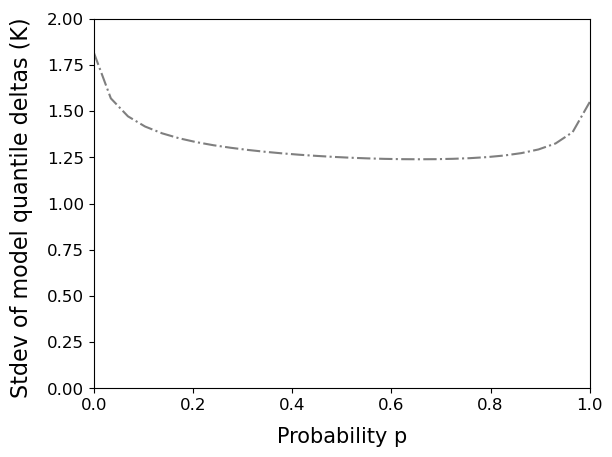

In [58]:
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.xlabel('Probability p',fontsize=15,labelpad=10)
plt.ylabel(r'Stdev of model quantile deltas (K) ',fontsize=16, labelpad=10)
# Define the title as a list of lines
# title_lines = [
#     r'Global, annual mean of standard deviation',
#     r'in $Q_f(p) - Q_i(p)$ among 18 CMIP6 models'
# ]
# # Plot with the modified title
# plt.title('\n'.join(title_lines), fontsize=15)
# plt.title(r'Global, annual mean of standard deviation \n'+r'in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models',fontsize=15)
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(0.1, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
# verticalalignment='top', bbox=props)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,2)
plt.xlim(0,1.0)

In [59]:
# %%time
# plt.plot(quants,qgmsc_gmae,label='Shift + Stretch',color='blue')
# plt.plot(quants,qgmc_gmae,'--',label = 'Shift',color='blue')
# plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
# plt.legend(loc='upper center',prop={'size':12},frameon=False)
# plt.title('')
# plt.ylabel('Mean Absolute Error (K)',fontsize=13)
# plt.xlabel('Probability p',fontsize=13,labelpad=10)
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,2.0)
# plt.show()

In [ ]:
%%time
plt.plot(quants,qgmsc_gmae,label=r'$L_2(Q_i^m)-Q_f^m$',color='blue')
plt.plot(quants,qgmc_gmae,'--',label = r'$L_1(Q_i^m) - Q_f^m$',color='blue')
plt.plot(quants,qgauss_gmae,label=r'$G_2(Q_i^m) - Q_f^m$',color='orange')
plt.plot(quants,qgaussmo_gmae,'--',label = r'$G_1(Q_i^m) - Q_f^m$',color='orange')
#plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
# specifying horizontal line type 
plt.axhline(y = 0,label = 'QDM + sort', color = 'r') 
plt.legend(loc='upper center',prop={'size':12},frameon=False)
plt.title('')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

### Extra plots - Ignore this section

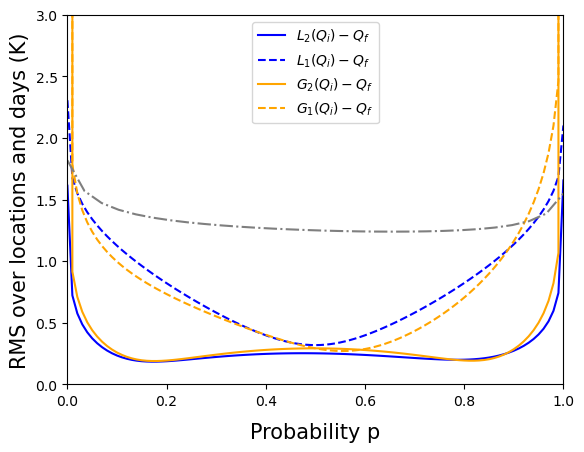

CPU times: user 2.68 s, sys: 153 ms, total: 2.84 s
Wall time: 2.83 s


In [60]:
%%time
plt.plot(quants,qgmsc_grmse,label=r'$L_2(Q_i)-Q_f$',color='blue')
plt.plot(quants,qgmc_grmse,'--',label = r'$L_1(Q_i) - Q_f$',color='blue')
plt.plot(quants,qgauss_grmse,label=r'$G_2(Q_i) - Q_f$',color='orange')
plt.plot(quants,qgaussmo_grmse,'--',label = r'$G_1(Q_i) - Q_f$',color='orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center')
plt.title('')
plt.ylabel('RMS over locations and days (K)',fontsize=15)
plt.xlabel('Probability p',fontsize=15,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [61]:
#Is L2 better than G2?
L2ltG2 = qgmsc_gmae < qgauss_gmae
L2ltG2.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [62]:
qgmsc_gmae.values

array([0.91266801, 0.37053961, 0.29225844, 0.24548082, 0.21206122,
       0.18643139, 0.16603791, 0.14947933, 0.13597248, 0.1249655 ,
       0.1160332 , 0.10885264, 0.10316266, 0.0987583 , 0.09546598,
       0.09311774, 0.09158149, 0.09070288, 0.09037594, 0.09050201,
       0.09101364, 0.09183904, 0.09291958, 0.09421114, 0.09566108,
       0.09720774, 0.09882778, 0.10047457, 0.10212971, 0.10375231,
       0.10533338, 0.10685429, 0.10830427, 0.10967239, 0.11094931,
       0.11214325, 0.11323687, 0.11423202, 0.11512677, 0.11592223,
       0.11661083, 0.11718722, 0.11766826, 0.11804053, 0.11830569,
       0.11847575, 0.11854653, 0.11852186, 0.11839904, 0.11816988,
       0.11784435, 0.11741941, 0.11689708, 0.11628605, 0.11557505,
       0.1147846 , 0.11390033, 0.11293721, 0.11188831, 0.11077041,
       0.10956991, 0.10830197, 0.1069722 , 0.10557966, 0.1041354 ,
       0.10264872, 0.10111643, 0.0995543 , 0.09798176, 0.09640515,
       0.09484545, 0.093312  , 0.09185097, 0.09046608, 0.08920

In [63]:
qano_std_agmean.values

array([1.81839762, 1.56943722, 1.47226187, 1.41705968, 1.38015611,
       1.35317367, 1.3324081 , 1.31579773, 1.30216332, 1.29048156,
       1.2804823 , 1.27192213, 1.26452121, 1.25822407, 1.25277815,
       1.24821316, 1.24467519, 1.2420058 , 1.24039354, 1.23985372,
       1.24036737, 1.24230723, 1.24585756, 1.25153673, 1.26016892,
       1.27309782, 1.29288206, 1.32523564, 1.38669937, 1.54969364])

In [64]:
#qgauss_ormse.values

In [65]:
qgauss_lrmse.loc[dict(quantile=0)]=1e10
qgauss_lrmse.loc[dict(quantile=1)]=1e10
qgauss_ormse.loc[dict(quantile=0)]=1e10
qgauss_ormse.loc[dict(quantile=1)]=1e10

In [66]:
qgauss_lmae.loc[dict(quantile=0)]=1e10
qgauss_lmae.loc[dict(quantile=1)]=1e10
qgauss_omae.loc[dict(quantile=0)]=1e10
qgauss_omae.loc[dict(quantile=1)]=1e10

CPU times: user 853 ms, sys: 66.5 ms, total: 920 ms
Wall time: 1.01 s


(0.0, 3.0)

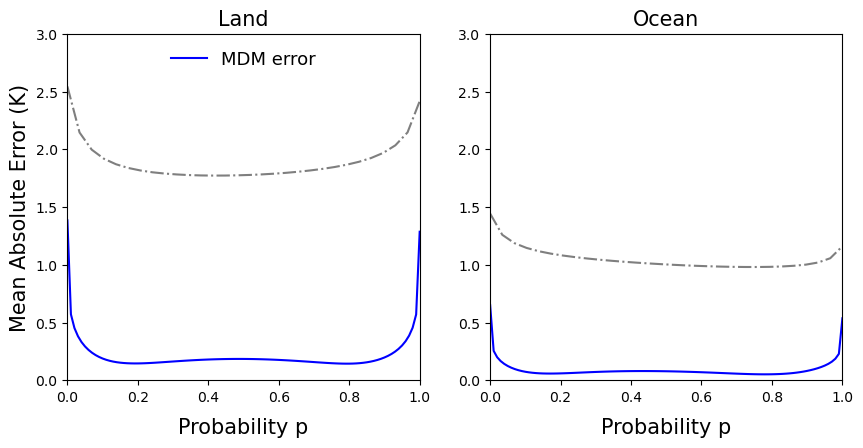

In [67]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lmae.plot(ax=axs[0],label='MDM error',color='blue')
# Scatter plot for the third line (Land)
# axs[0].scatter(quants30, qano_std_almean, linestyle='-.',color='tab:gray')
qano_std_almean.plot(ax=axs[0], linestyle='-.',color='tab:gray')
axs[0].set_title('Land',fontsize=15)
axs[0].set_xlabel('Probability p',fontsize=15,labelpad=10)
axs[0].set_ylabel('Mean Absolute Error (K)',fontsize=15)
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='upper center',fontsize=13,frameon=False)
#
im = qgmsc_omae.plot(ax=axs[1],color='blue')
# axs[1].scatter(quants30, qano_std_aomean, marker='-.',color='tab:gray')
qano_std_aomean.plot(ax=axs[1], linestyle='-.', color='tab:gray')
axs[1].set_title('Ocean',fontsize=15)
axs[1].set_xlabel('Probability p',fontsize=15,labelpad=10)
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
# axs[1].legend(loc='center right')
#plot.show()

CPU times: user 1.24 s, sys: 99 ms, total: 1.33 s
Wall time: 1.51 s


(0.0, 3.0)

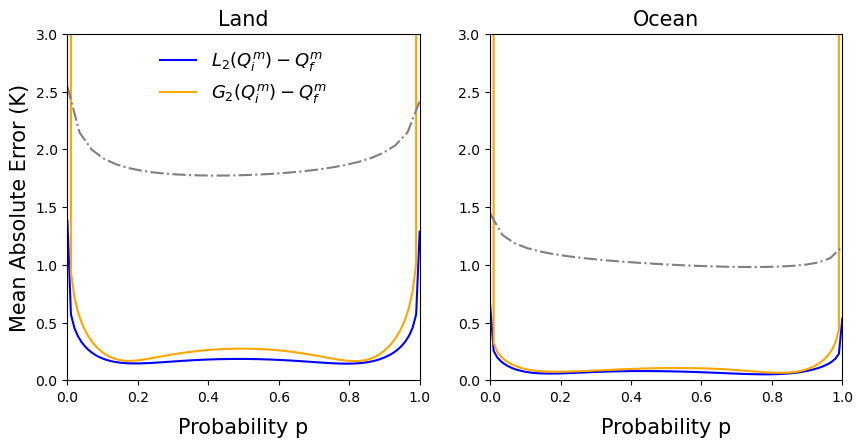

In [68]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lmae.plot(ax=axs[0],label=r'$L_2(Q_i^m) - Q_f^m$',color='blue')
qgauss_lmae.plot(ax=axs[0],label=r'$G_2(Q_i^m) -Q_f^m$',color='orange')
# Scatter plot for the third line (Land)
# axs[0].scatter(quants30, qano_std_almean, linestyle='-.',color='tab:gray')
qano_std_almean.plot(ax=axs[0], linestyle='-.',color='tab:gray')
axs[0].set_title('Land',fontsize=15)
axs[0].set_xlabel('Probability p',fontsize=15,labelpad=10)
axs[0].set_ylabel('Mean Absolute Error (K)',fontsize=15)
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='upper center',fontsize=13,frameon=False)
#
im = qgmsc_omae.plot(ax=axs[1],color='blue')
qgauss_omae.plot(ax=axs[1],color='orange')
# axs[1].scatter(quants30, qano_std_aomean, marker='-.',color='tab:gray')
qano_std_aomean.plot(ax=axs[1], linestyle='-.', color='tab:gray')
axs[1].set_title('Ocean',fontsize=15)
axs[1].set_xlabel('Probability p',fontsize=15,labelpad=10)
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
# axs[1].legend(loc='center right')
#plot.show()

CPU times: user 1.28 s, sys: 104 ms, total: 1.38 s
Wall time: 1.59 s


(0.0, 3.0)

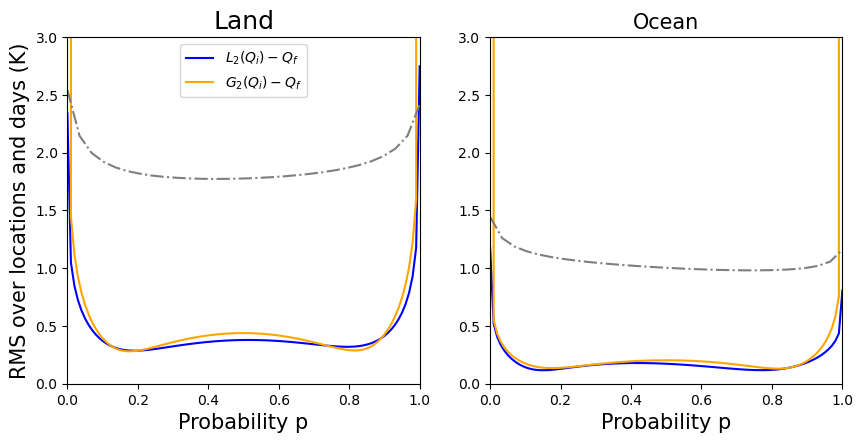

In [69]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lrmse.plot(ax=axs[0],label=r'$L_2(Q_i) - Q_f$',color='blue')
qgauss_lrmse.plot(ax=axs[0],label=r'$G_2(Q_i) -Q_f$',color='orange')
# Scatter plot for the third line (Land)
# axs[0].scatter(quants30, qano_std_almean, linestyle='-.',color='tab:gray')
qano_std_almean.plot(ax=axs[0], linestyle='-.',color='tab:gray')
axs[0].set_title('Land',fontsize=18)
axs[0].set_xlabel('Probability p',fontsize=15)
axs[0].set_ylabel('RMS over locations and days (K)',fontsize=15)
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='upper center')
#
im = qgmsc_ormse.plot(ax=axs[1],color='blue')
qgauss_ormse.plot(ax=axs[1],color='orange')
# axs[1].scatter(quants30, qano_std_aomean, marker='-.',color='tab:gray')
qano_std_aomean.plot(ax=axs[1], linestyle='-.', color='tab:gray')
axs[1].set_title('Ocean',fontsize=15)
axs[1].set_xlabel('Probability p',fontsize=15)
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
# axs[1].legend(loc='center right')
#plot.show()

#### Fraction of days and locations for which the error curves are below CMIP6 curves.

In [70]:
qgmsc_aerr

<xarray.DataArray 'Errors' (quantile: 101, lat: 192, lon: 288, day: 365)>
dask.array<fabs, shape=(101, 192, 288, 365), dtype=float64, chunksize=(101, 20, 40, 10), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 327 328 329 330 331 332 333 334
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086

In [71]:
qgmsc_aerr_land = qgmsc_aerr.where(landfrac==1).isel(time=0)
qgmsc_aerr_land = qgmsc_aerr_land.rename({'day':'dayofyear'})
qgmsc_aerr_land

<xarray.DataArray 'Errors' (quantile: 101, lat: 192, lon: 288, dayofyear: 365)>
dask.array<getitem, shape=(101, 192, 288, 365), dtype=float64, chunksize=(101, 20, 40, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 328 329 330 331 332 333 334
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member     int64 0
  * quantile   (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year       int64 2086
    ym         int64 2086
    time       object 2100-01-01 00:00:00

In [72]:
qano_land         = xr.open_zarr(cvals_det+'cmip6_qano_annual_land.zarr').tasmax
qano_std_land     = qano_land.std('source_id')
qano_std_land

<xarray.DataArray 'tasmax' (quantile: 30, dayofyear: 365, lat: 61, lon: 121)>
dask.array<_sqrt, shape=(30, 365, 61, 121), dtype=float64, chunksize=(30, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [73]:
# Step 1: Interpolation to Match LAT and LON Coordinates
# We first match the grid of qgmsc_abserr_land to qano_std_land using interp and
# Interpolate qgmsc_abserr_land's 100 quantiles to match qano_std_land's 30 quantile values.
qgmsc_aerr_land_interp = qgmsc_aerr_land.interp(lat=qano_std_land.lat, lon=qano_std_land.lon).\
                           interp(quantile=qano_std_land['quantile'].values)
# qgmsc_abserr_land_interp = qgmsc_abserr_land_interp.drop_isel(quantile=[0,1,2,27,28,29])
qgmsc_aerr_land_interp

<xarray.DataArray 'Errors' (quantile: 30, lat: 61, lon: 121, dayofyear: 365)>
dask.array<transpose, shape=(30, 61, 121, 365), dtype=float64, chunksize=(30, 61, 121, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 328 329 330 331 332 333 334
    member     int64 0
    year       int64 2086
    ym         int64 2086
    time       object 2100-01-01 00:00:00
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [74]:
# Step 2: Determine land mask based on non-NaN values in the original dataset
# We'll use qgmsc_abserr_land as a reference for the land mask. Adjust this choice if needed.
land_mask = ~np.isnan(qgmsc_aerr_land_interp.isel(dayofyear=0, quantile=0))

# Step 2: Calculate the total number of valid land locations using the land mask
total_land_locations = land_mask.sum().values
total_land_locations

array(2112)

CPU times: user 9 s, sys: 354 ms, total: 9.35 s
Wall time: 11.2 s


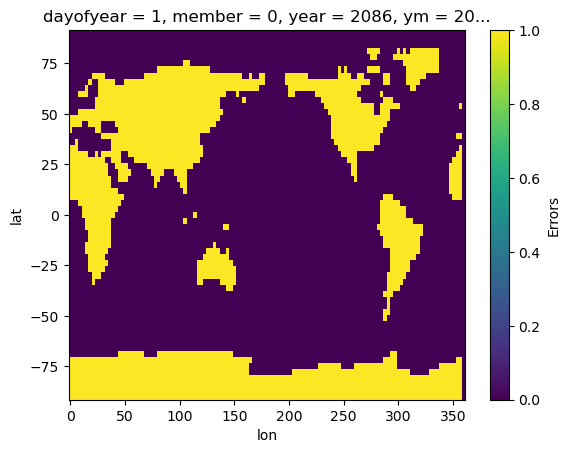

In [75]:
%%time
#Check if the land mask makes sense
land_mask.plot()

In [76]:
# Step 3: Perform Comparison
# Check for each quantile, day, LAT, and LON if qgmsc_abserr_land_quant_interp's value 
#is less than qano_std_land value.
# Mask where either of the data is not NaN
mask_valid           = ~np.isnan(qgmsc_aerr_land_interp) & ~np.isnan(qano_std_land)
comparison_msc_cmip6 = ((qgmsc_aerr_land_interp < qano_std_land) & mask_valid)
#At this stage, all the ocean locations and the locations, days and quantiles where 
#the condition has failed will have the values 'False'
comparison_msc_cmip6

<xarray.DataArray (quantile: 30, lat: 61, lon: 121, dayofyear: 365)>
dask.array<and_, shape=(30, 61, 121, 365), dtype=bool, chunksize=(30, 16, 31, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 328 329 330 331 332 333 334
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
    member     int64 0
    year       int64 2086
    ym         int64 2086
    time       object 2100-01-01 00:00:00

In [77]:
# mask_valid.sel(lat=0,lon=9,method='nearest').sel(dayofyear=5).values

In [78]:
# qano_std_land.sel(lat=0,lon=9,method='nearest').sel(dayofyear=5).values

In [79]:
# qgmsc_abserr_land_interp.sel(lat=0,lon=9,method='nearest').sel(dayofyear=5).values

In [80]:
# comparison_msc_cmip6.sel(lat=0,lon=9,method='nearest').sel(dayofyear=5).values

In [81]:
# Step 3: Check All Quantiles
# For a given day and location, we ensure that ALL quantiles from qgmsc_abserr_land_quant_interp are 
#less than qano_std_land.
all_msc_lessthan_cmip6 = comparison_msc_cmip6.drop_sel(quantile=[0.0,1.0]).all(dim='quantile')
all_msc_lessthan_cmip6

<xarray.DataArray (lat: 61, lon: 121, dayofyear: 365)>
dask.array<all-aggregate, shape=(61, 121, 365), dtype=bool, chunksize=(16, 31, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 328 329 330 331 332 333 334
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
    member     int64 0
    year       int64 2086
    ym         int64 2086
    time       object 2100-01-01 00:00:00

In [82]:
%%time
# Step 4: Sum over Days and Locations
# Sum up all the instances where the condition (all quantiles of L2 are less than CMIP curve) holds true.
sum_msc_lessthan_cmip6 = all_msc_lessthan_cmip6.sum(dim=['dayofyear', 'lat', 'lon'])
sum_msc_lessthan_cmip6 = sum_msc_lessthan_cmip6.values
sum_msc_lessthan_cmip6 

CPU times: user 6min 39s, sys: 11.6 s, total: 6min 50s
Wall time: 7min 6s


array(732685)

In [83]:
fractions = sum_msc_lessthan_cmip6/(365*total_land_locations)
fractions

0.9504527293482773

##### Plot of land/ocean annual RMSEs and error fractions 

CPU times: user 5.19 s, sys: 292 ms, total: 5.48 s
Wall time: 5.91 s


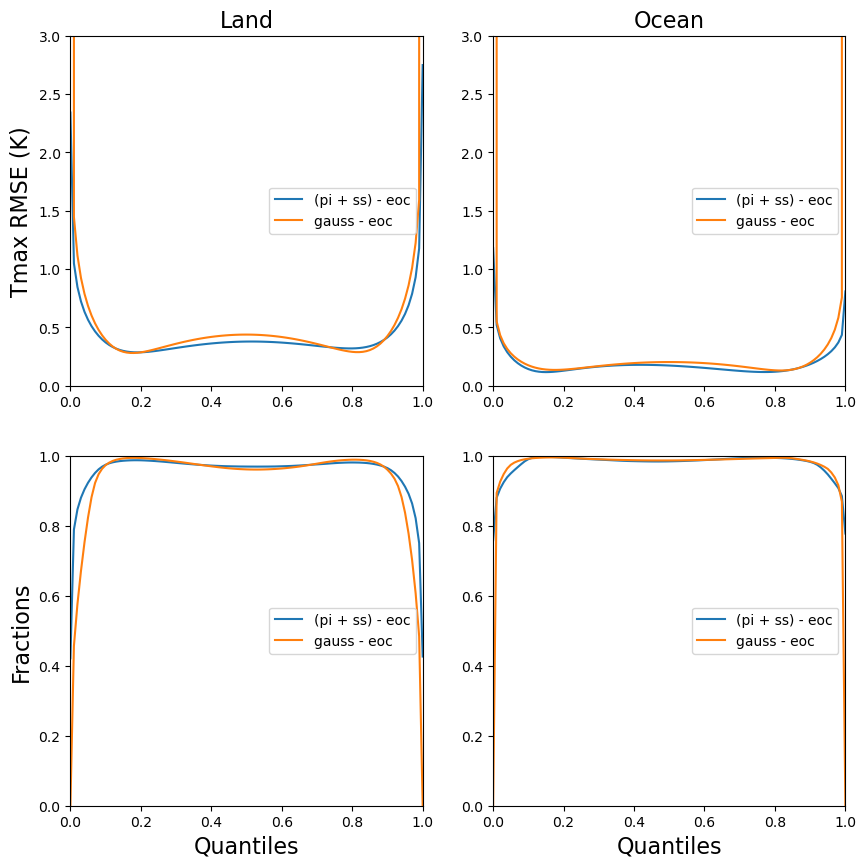

In [84]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

im1 = qgmsc_lrmse.plot(ax=axs[0,0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0,0],label='gauss - eoc')
axs[0,0].set_title('Land',fontsize=16)
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Tmax RMSE (K)',fontsize=16)
axs[0,0].set_xlim(0.0,1.0)
axs[0,0].set_ylim(0.0,3.0)
axs[0,0].legend(loc='center right')
#
im2 = qgmsc_ormse.plot(ax=axs[0,1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[0,1],label='gauss - eoc')
axs[0,1].set_title('Ocean',fontsize=16)
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,1].set_xlim(0.0,1.0)
axs[0,1].set_ylim(0.0,3.0)
axs[0,1].legend(loc='center right')
#
im3 = qgmsc_land_errfracn1.plot(ax=axs[1,0],label='(pi + ss) - eoc')
qgauss_land_errfracn1.plot(ax=axs[1,0],label='gauss - eoc')
axs[1,0].set_title('')
axs[1,0].set_xlabel('Quantiles',fontsize=16)
axs[1,0].set_ylabel('Fractions',fontsize=16)
axs[1,0].set_xlim(0.0,1.0)
axs[1,0].set_ylim(0.0,1.0)
axs[1,0].legend(loc='center right')
#
im4 = qgmsc_ocean_errfracn1.plot(ax=axs[1,1],label='(pi + ss) - eoc')
qgauss_ocean_errfracn1.plot(ax=axs[1,1],label='gauss - eoc')
axs[1,1].set_title('')
axs[1,1].set_xlabel('Quantiles',fontsize=16)
axs[1,1].set_ylabel('')
axs[1,1].set_xlim(0.0,1.0)
axs[1,1].set_ylim(0.0,1.0)
axs[1,1].legend(loc='center right')
# plot.show()

In [85]:
%%time
error_redn = qgmsc_grmse.integrate('quantile')/qgmc_grmse.integrate('quantile')
error_redn.values

CPU times: user 395 ms, sys: 38.4 ms, total: 433 ms
Wall time: 518 ms


array(0.3529502)

### <span style ='color:Red'> Check CLT -This is extra code. Please ignore! </span>

In [86]:
# Take a zonal average (weighted mean over longitude)
# weights      = np.cos(np.deg2rad(qgmsc_err.lat))
# weights.name = "weights"
# #
# qgmsc_err_weighted     = qgmsc_err.weighted(weights)
# qgauss_err_weighted    = qgauss_err.weighted(weights)
# #
# qgmsc_err_zmean     = qgmsc_err_weighted.mean('lon')
# qgauss_err_zmean    = qgauss_err_weighted.mean('lon')

In [87]:
# %%time
# tgmw_d  = to_daily(tgmw)
# tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
# tgmw_d1 = tgmw_d.sel(year=slice(ic_year0,ic_year1))
# tgmw_d1 = tgmw_d1.chunk({'day':30})
# tgmw_d1

In [88]:
# %%time
# #Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
# #This works because of the way xarray stacks two dimensions. window_len =30. 
# #I have called the 'window' dimension 'index'.
# quants             = np.arange(0,1.01,0.01)
# N_mem              = 100
# window_len         = 30
# #r = roll, ndrop = drop NANs
# tgmw_eocroll       = stack_roll(tgmw_d1,N_mem*window_len,N_mem)
# tgmw_piroll        = stack_roll(tgmw_d0,N_mem*window_len,N_mem)
# #########
# tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
# tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
# tgmw_piroll0

In [89]:
# tgmw_eocmroll = tgmw_eocroll0.mean('index')
# tgmw_eocsroll = tgmw_eocroll0.std('index')
# qgmw_eocroll  = tgmw_eocroll0.quantile(quants,dim='index',skipna=False)
# ######################

In [90]:
# # Generate normal distributions using means and standard deviations
# index = np.arange(3000) 

# gaussians_eoc = xr.apply_ufunc(
#     np.random.normal,
#     tgmw_eocmroll,
#     tgmw_eocsroll,
#     input_core_dims=[[], []],
#     output_core_dims=[['index']],
#     vectorize=True,
#     output_dtypes=[float],
#     kwargs={'size': 3000},
#      output_sizes={'index': 3000},
#     dask='parallelized'
# )

In [91]:
# qgauss_eoc = gaussians_eoc.quantile(quants,dim='index',skipna=False)

In [92]:
# qgmw_gauss_diff   = qgauss_eoc - qgmw_eocroll

In [93]:
# ### ###Save ######
# qgmw_gauss_diffpath      = cvals+'qgmw_gauss_diff'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# #qgmw_gauss_diff.to_dataset().to_zarr(qgmw_gauss_diffpath,mode='w')

In [94]:
# qgmw_gauss_diff   = xr.open_zarr(qgmw_gauss_diff)
# qgmw_gauss_diff   = qgmw_gauss_diff.TREFHTMX

In [95]:
# qgmw_gesq                   = qgmw_gauss_diff**2
# qgmw_gauss_serror_weighted  = qgmw_gesq.weighted(weights)
# qgmw_gauss_serror_gmean     = qgmw_gauss_serror_weighted.mean({'lat','lon'})
# ################################################

In [96]:
# qgmw_gauss_gmse            = qgmw_gauss_serror_gmean.mean('day')
# qgmw_gauss_grmse           = np.sqrt(qgmw_gauss_gmse)
# qgmw_gauss_grmse 

In [97]:
# %%time
# qgmw_gauss_grmsepath = cvals+'qgmw_gauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
# ##########################
# #qgmw_gauss_grmse.to_dataset().to_zarr(qgmw_gauss_grmsepath,mode='w')

In [98]:
# qgmw_gauss_grmse = xr.open_zarr(qgmw_gauss_grmsepath)
# qgmw_gauss_grmse = qgmw_gauss_grmse.TREFHTMX

In [99]:
# %%time
# plt.plot(quants,qgmw_grmse,label='eoc - pi',color='tab:blue')
# plt.plot(quants,qgmw_gauss_grmse,label='eoc - gaussian',color='red')
# plt.plot(quants,qgmc_grmse,label='eoc - (pi + shift)',color='tab:orange')
# plt.plot(quants,qgmsc_grmse,label='eoc - (pi + shift + stretch)',color='tab:green')
# plt.legend(loc='center right')
# plt.title('CESM2: Global,annual RMSEs')
# plt.ylabel('Tmax RMSE (K)')
# plt.xlabel('Percentiles')
# plt.xlim(0.0,1.0)
# plt.ylim(0.0,5.0)
# plt.show()